In [214]:
import pandas, matplotlib.pyplot
import seaborn
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import fuzz
from thefuzz import process
from datetime import datetime
import numpy as np
import missingno as msno

from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

pd.options.display.float_format = "{:,.2f}".format



In [2]:
storms = pd.read_csv('../data/storms.csv', index_col=0)

In [104]:
storms.head(20)

,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter
1,Amy,1975,6,27,0,27.50,-79.00,tropical depression,0.00,25,1013,125.47,4.56
2,Amy,1975,6,27,6,28.50,-79.00,tropical depression,0.00,25,1013,125.47,4.56
3,Amy,1975,6,27,12,29.50,-79.00,tropical depression,0.00,25,1013,125.47,4.56
4,Amy,1975,6,27,18,30.50,-79.00,tropical depression,0.00,25,1013,125.47,4.56
5,Amy,1975,6,28,0,31.50,-78.80,tropical depression,0.00,25,1012,125.47,4.56
6,Amy,1975,6,28,6,32.40,-78.70,tropical depression,0.00,25,1012,125.47,4.56
7,Amy,1975,6,28,12,33.30,-78.00,tropical depression,0.00,25,1011,125.47,4.56
8,Amy,1975,6,28,18,34.00,-77.00,tropical depression,0.00,30,1006,125.47,4.56
9,Amy,1975,6,29,0,34.40,-75.80,tropical storm,0.00,35,1004,125.47,4.56
10,Amy,1975,6,29,6,34.00,-74.80,tropical storm,0.00,40,1002,125.47,4.56


In [4]:
storms.dtypes

name                             object
year                              int64
month                             int64
day                               int64
hour                              int64
lat                             float64
long                            float64
status                           object
category                        float64
wind                              int64
pressure                          int64
tropicalstorm_force_diameter    float64
hurricane_force_diameter        float64
dtype: object

In [5]:
storms.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19066 entries, 1 to 19066
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          19066 non-null  object 
 1   year                          19066 non-null  int64  
 2   month                         19066 non-null  int64  
 3   day                           19066 non-null  int64  
 4   hour                          19066 non-null  int64  
 5   lat                           19066 non-null  float64
 6   long                          19066 non-null  float64
 7   status                        19066 non-null  object 
 8   category                      4684 non-null   float64
 9   wind                          19066 non-null  int64  
 10  pressure                      19066 non-null  int64  
 11  tropicalstorm_force_diameter  9554 non-null   float64
 12  hurricane_force_diameter      9554 non-null   float64
dtypes: flo

In [6]:
storms[['category','tropicalstorm_force_diameter','hurricane_force_diameter']].isnull().value_counts()

category  tropicalstorm_force_diameter  hurricane_force_diameter
True      False                         False                       7503
          True                          True                        6879
False     True                          True                        2633
          False                         False                       2051
Name: count, dtype: int64

In [7]:
#Fillna to category features according to the wind speed

#cond = storms['tropicalstorm_force_diameter'].notnull() & storms['hurricane_force_diameter'].notnull()

storms.loc[storms['wind'] < 74, 'category'] = 0
storms.loc[storms['wind'] >= 74  , 'category'] = 1
storms.loc[storms['wind'] >= 96 , 'category'] = 2
storms.loc[storms['wind'] >= 111 , 'category'] = 3
storms.loc[storms['wind'] >= 130 , 'category'] = 4
storms.loc[storms['wind'] >= 156 , 'category'] = 5

#storms['category'] = storms.apply(lambda row: row['category'] if ~(np.isnan(row['tropicalstorm_force_diameter'])) else row)

In [8]:
storms['category'].value_counts()

category
0.00    15866
1.00     1966
2.00      580
3.00      421
4.00      228
5.00        5
Name: count, dtype: int64

In [9]:
storms[['category','tropicalstorm_force_diameter','hurricane_force_diameter']].isnull().value_counts()

category  tropicalstorm_force_diameter  hurricane_force_diameter
False     False                         False                       9554
          True                          True                        9512
Name: count, dtype: int64

In [10]:

#Assesing percentage of missing values by features

missing = pd.concat([storms.isnull().sum(), 100*storms.isnull().sum()/storms.shape[0]], axis=1)
missing.columns = ['Count', '%']
missing.sort_values(by='%', ascending=False, inplace=True)

missing[missing['%']>10]

,Count,%
tropicalstorm_force_diameter,9512,49.89
hurricane_force_diameter,9512,49.89


In [12]:
#Identifying the category for null values in tropicalstorm_force_diameter and hurricane_force_diameter

storms_temp = storms.dropna()

storms_temp.isnull().sum()


name                            0
year                            0
month                           0
day                             0
hour                            0
lat                             0
long                            0
status                          0
category                        0
wind                            0
pressure                        0
tropicalstorm_force_diameter    0
hurricane_force_diameter        0
dtype: int64

In [16]:
# define function to create scatterplots of Storm category against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.8)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = 'category', y = col, data=storms, alpha=0.5)
        ax.set(xlabel='category', ylabel=col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [17]:
#Use a list comprehension to build a list of features from the columns of `storms` that
#excluding features which are not interested

features = [x for x in storms.columns if x not in ['name']]


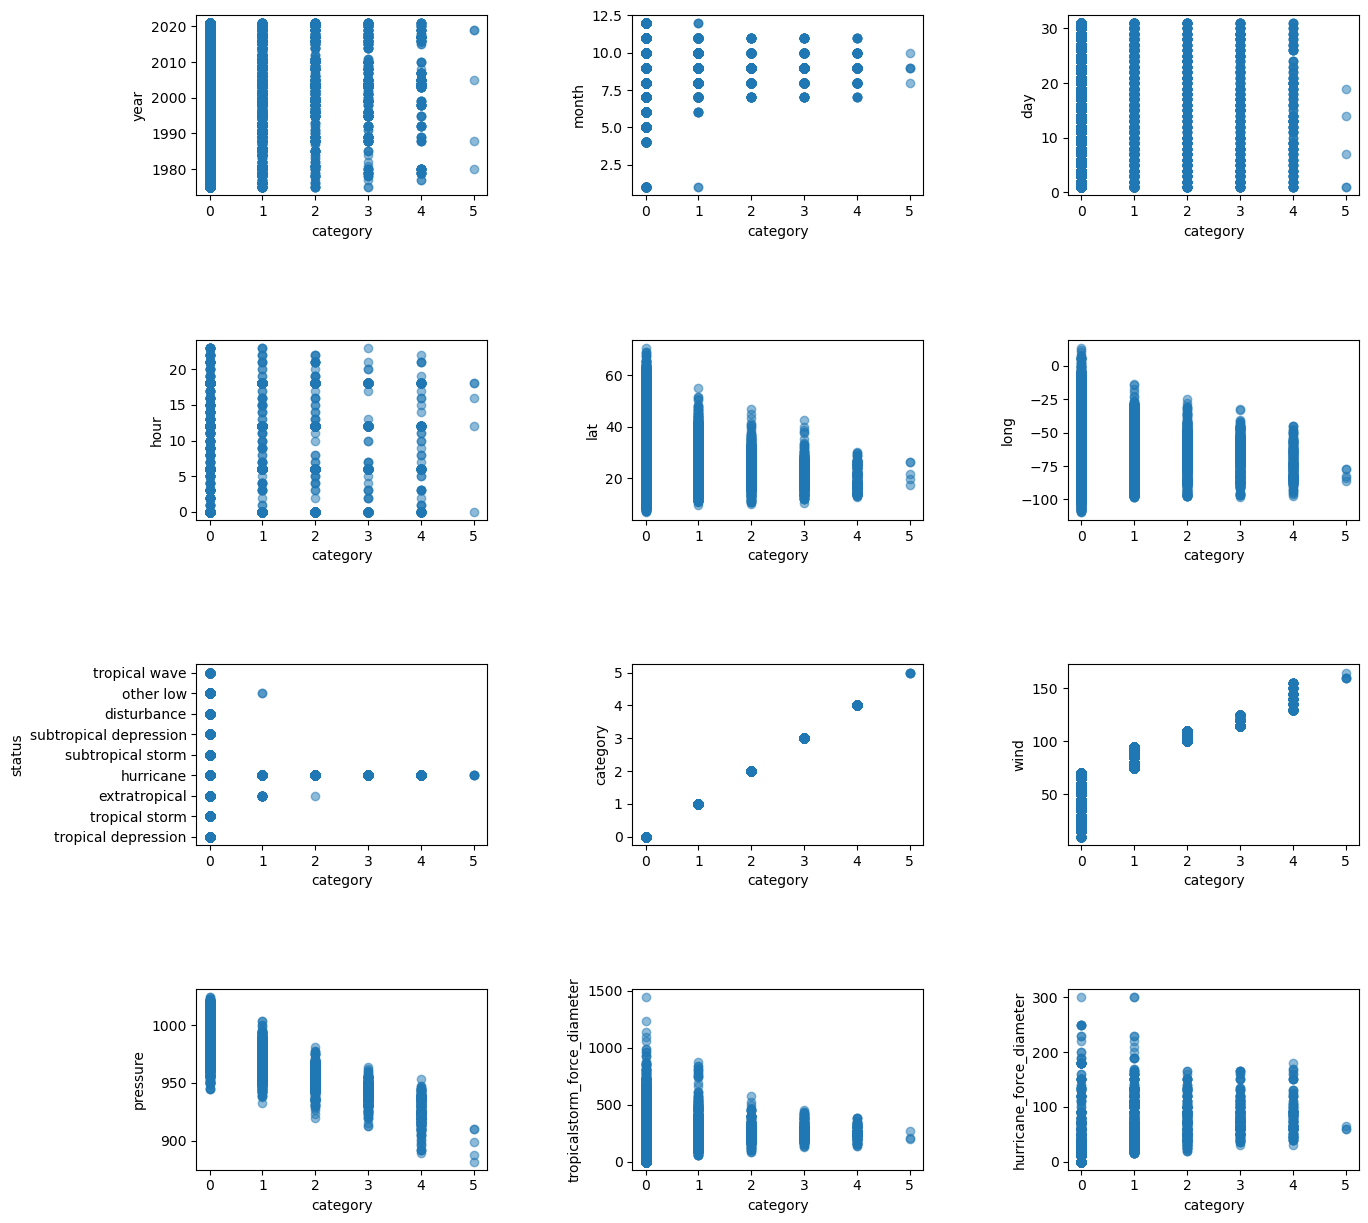

In [18]:
scatterplots(features, ncol=3, figsize=(15, 15))

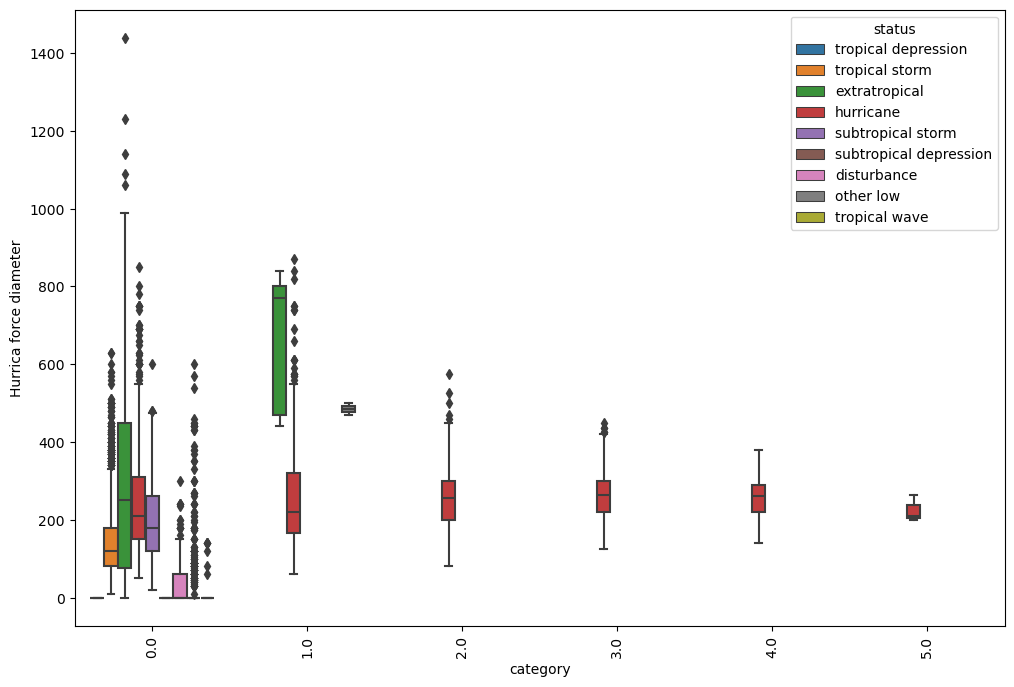

In [29]:
#Create a seaborn boxplot of the storms dataframe,
#with 'category' on the x-axis, 'tropicalstorm_force_diameter' as the y-value, and a hue that indicates 'status'
#This will use boxplot's x, y, hue, and data arguments.
plt.subplots(figsize=(12, 8))
sns.boxplot(x='category', y='tropicalstorm_force_diameter', hue='status', data=storms)
plt.xticks(rotation='vertical')
plt.ylabel('Hurrica force diameter')
plt.xlabel('category');


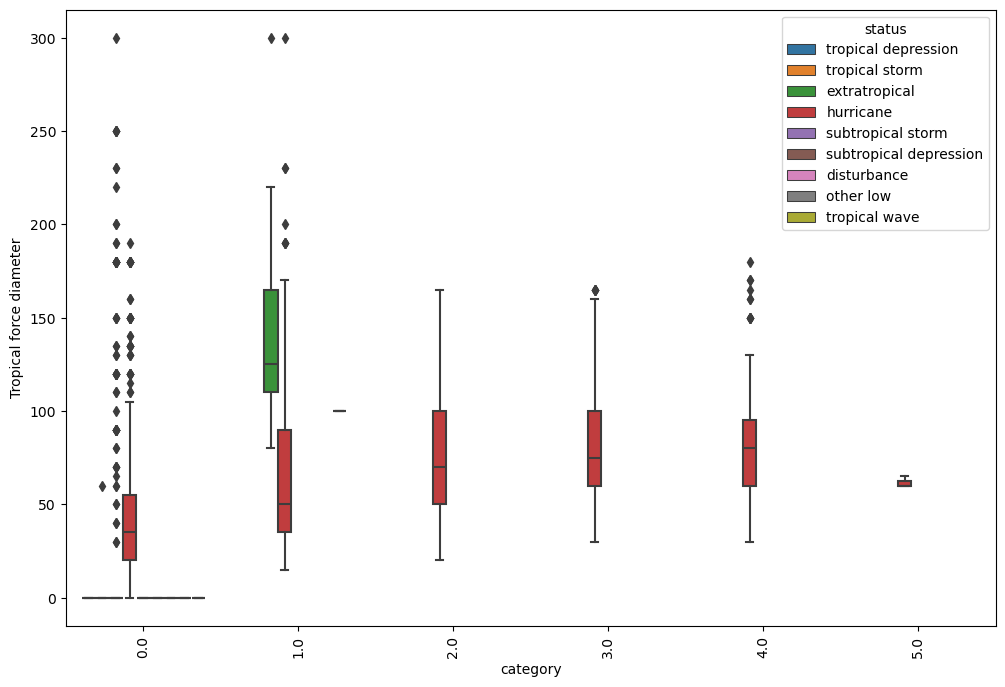

In [28]:
#Create a seaborn boxplot of the storms dataframe,
#with 'category' on the x-axis, 'tropicalstorm_force_diameter' as the y-value, and a hue that indicates 'status'
#This will use boxplot's x, y, hue, and data arguments.
plt.subplots(figsize=(12, 8))
sns.boxplot(x='category', y='hurricane_force_diameter', hue='status', data=storms)
plt.xticks(rotation='vertical')
plt.ylabel('Tropical force diameter')
plt.xlabel('category');


In [31]:
storms.status.value_counts()

status
tropical storm            6684
hurricane                 4684
tropical depression       3525
extratropical             2068
other low                 1405
subtropical storm          292
subtropical depression     151
disturbance                146
tropical wave              111
Name: count, dtype: int64

In [46]:
target_status = ['tropical storm','hurricane','tropical depression']

storms = storms[storms['status'].isin(target_status)]

storms.status.value_counts()

status
tropical storm         6684
hurricane              4684
tropical depression    3525
Name: count, dtype: int64

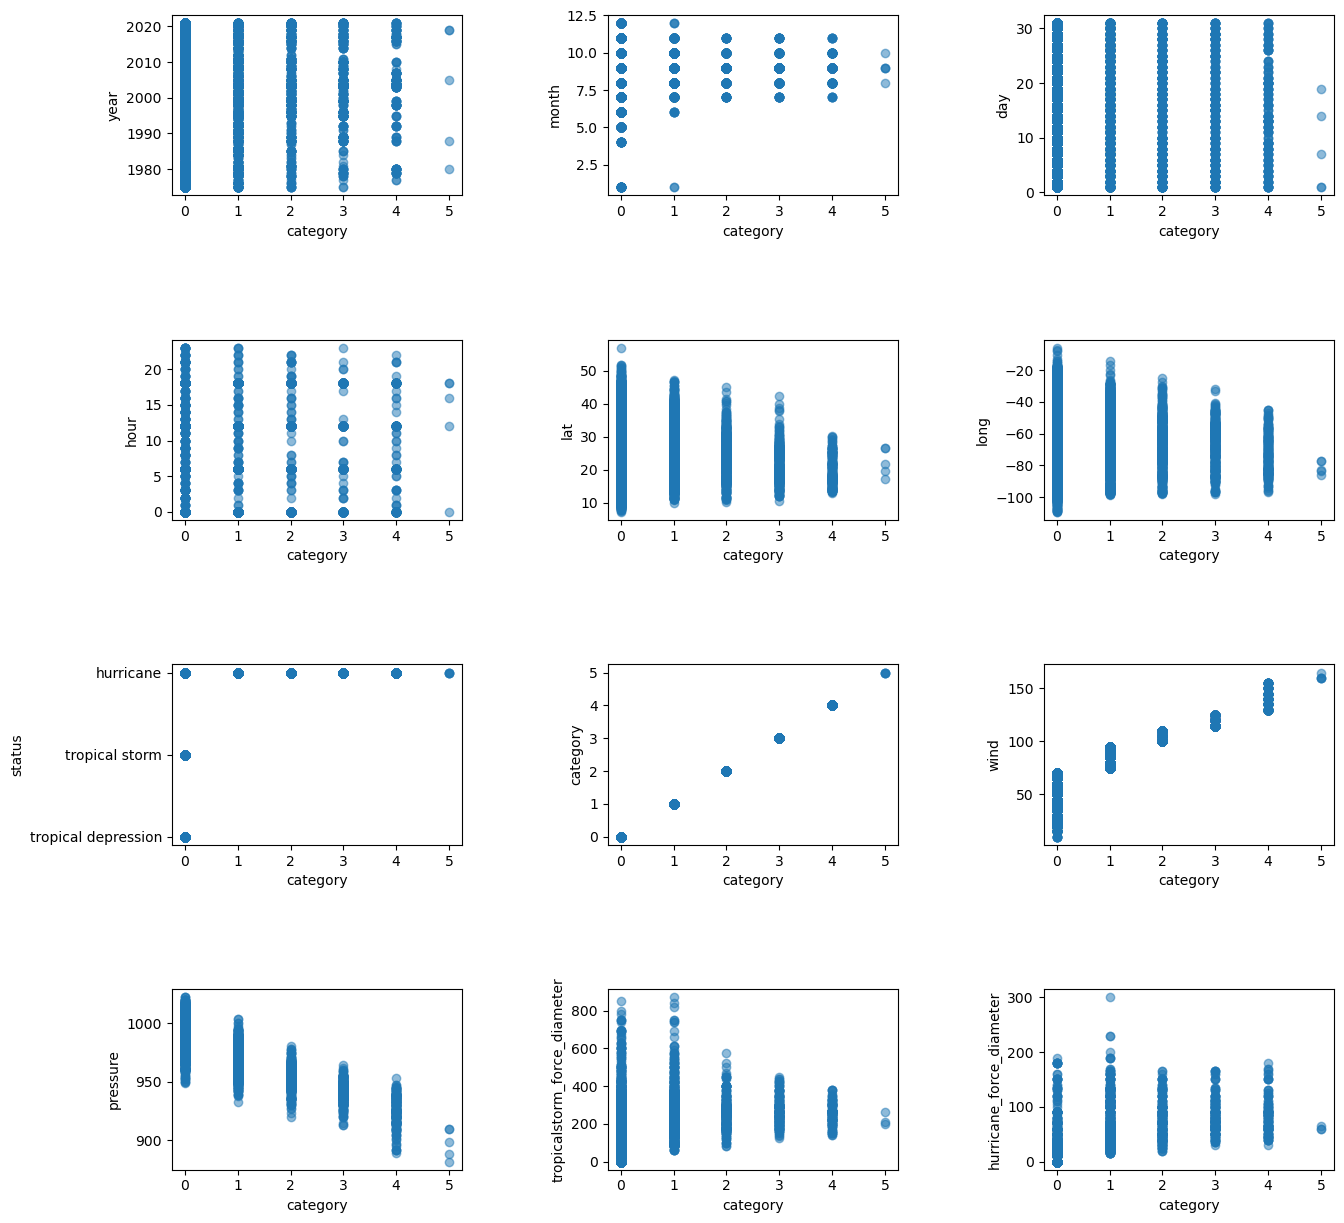

In [47]:
scatterplots(features, ncol=3, figsize=(15, 15))

In [48]:
storms[['tropicalstorm_force_diameter','hurricane_force_diameter']].describe()

,tropicalstorm_force_diameter,hurricane_force_diameter
count,"6,744.00","6,744.00"
mean,148.40,19.26
std,125.77,36.07
min,0.00,0.00
25%,60.00,0.00
50%,130.00,0.00
75%,220.00,30.00
max,870.00,300.00


In [49]:
diameter_mean = storms_temp.groupby('category')[['tropicalstorm_force_diameter','hurricane_force_diameter']].mean()
diameter_mean.round(2)


,tropicalstorm_force_diameter,hurricane_force_diameter
category,,
0.00,125.47,4.56
1.00,260.79,65.75
2.00,261.30,75.58
3.00,270.46,82.27
4.00,254.89,83.21
5.00,225.00,61.67


In [50]:
storms.category.value_counts()

category
0.00    11719
1.00     1941
2.00      579
3.00      421
4.00      228
5.00        5
Name: count, dtype: int64

In [51]:
diameter_mean_cat0 = diameter_mean[diameter_mean.index == 0]
diameter_mean_cat0



,tropicalstorm_force_diameter,hurricane_force_diameter
category,,
0.00,125.47,4.56


In [86]:
diameter_mean.iloc[1,1]


65.74582338902148

In [53]:
#Fill NA values in tropicalstorm_force_diameter column with the mean value depending on storm category



storms.loc[storms['category'] == 0, 'tropicalstorm_force_diameter'] = storms.loc[storms['category'] == 0,
                                                                        'tropicalstorm_force_diameter'].fillna(diameter_mean.iloc[0,0])
storms.loc[storms['category'] == 1, 'tropicalstorm_force_diameter'] = storms.loc[storms['category'] == 1,
                                                                        'tropicalstorm_force_diameter'].fillna(diameter_mean.iloc[1,0])
storms.loc[storms['category'] == 2, 'tropicalstorm_force_diameter'] = storms.loc[storms['category'] == 2,
                                                                        'tropicalstorm_force_diameter'].fillna(diameter_mean.iloc[2,0])
storms.loc[storms['category'] == 3, 'tropicalstorm_force_diameter'] = storms.loc[storms['category'] == 3,
                                                                        'tropicalstorm_force_diameter'].fillna(diameter_mean.iloc[3,0])
storms.loc[storms['category'] == 4, 'tropicalstorm_force_diameter'] = storms.loc[storms['category'] == 4,
                                                                        'tropicalstorm_force_diameter'].fillna(diameter_mean.iloc[4,0])
storms.loc[storms['category'] == 5, 'tropicalstorm_force_diameter'] = storms.loc[storms['category'] == 5,
                                                                        'tropicalstorm_force_diameter'].fillna(diameter_mean.iloc[5,0])



In [87]:
#Fill NA values in hurricane_force_diameter column with the mean value depending on storm category



storms.loc[storms['category'] == 0, 'hurricane_force_diameter'] = storms.loc[storms['category'] == 0,
                                                                        'hurricane_force_diameter'].fillna(diameter_mean.iloc[0,1])
storms.loc[storms['category'] == 1, 'hurricane_force_diameter'] = storms.loc[storms['category'] == 1,
                                                                        'hurricane_force_diameter'].fillna(diameter_mean.iloc[1,1])
storms.loc[storms['category'] == 2, 'hurricane_force_diameter'] = storms.loc[storms['category'] == 2,
                                                                        'hurricane_force_diameter'].fillna(diameter_mean.iloc[2,1])
storms.loc[storms['category'] == 3, 'hurricane_force_diameter'] = storms.loc[storms['category'] == 3,
                                                                        'hurricane_force_diameter'].fillna(diameter_mean.iloc[3,1])
storms.loc[storms['category'] == 4, 'hurricane_force_diameter'] = storms.loc[storms['category'] == 4,
                                                                        'hurricane_force_diameter'].fillna(diameter_mean.iloc[4,1])
storms.loc[storms['category'] == 5, 'hurricane_force_diameter'] = storms.loc[storms['category'] == 5,
                                                                        'hurricane_force_diameter'].fillna(diameter_mean.iloc[5,1])

<Axes: >

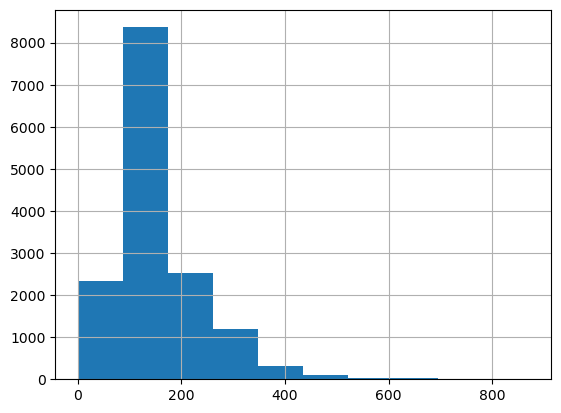

In [88]:
storms['tropicalstorm_force_diameter'].hist()

<Axes: >

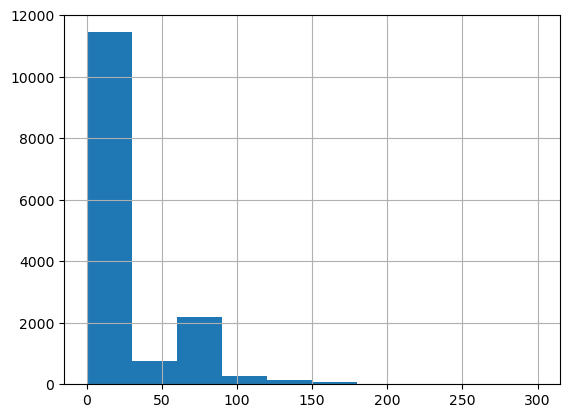

In [89]:
storms['hurricane_force_diameter'].hist()

In [90]:
storms.loc[storms['category'] == 0, 'tropicalstorm_force_diameter'].isna().value_counts()


tropicalstorm_force_diameter
False    11719
Name: count, dtype: int64

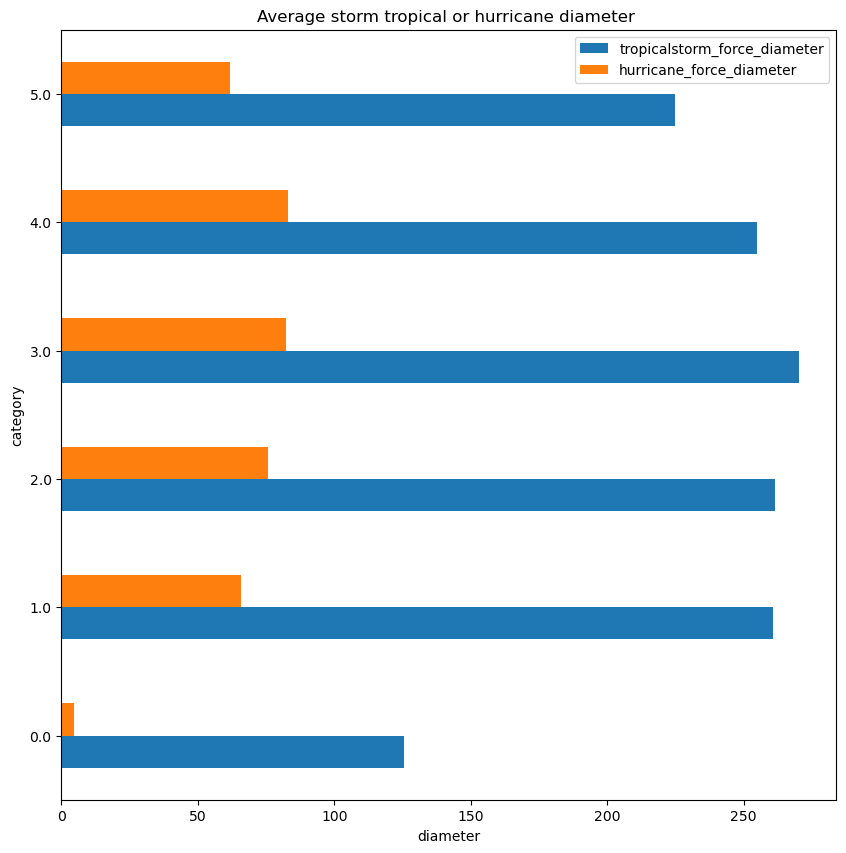

In [92]:
(diameter_mean.reindex(index=diameter_mean.mean(axis=1).index)
    .plot(kind='barh', figsize=(10, 10), title='Average storm tropical or hurricane diameter '))
plt.xlabel('diameter');



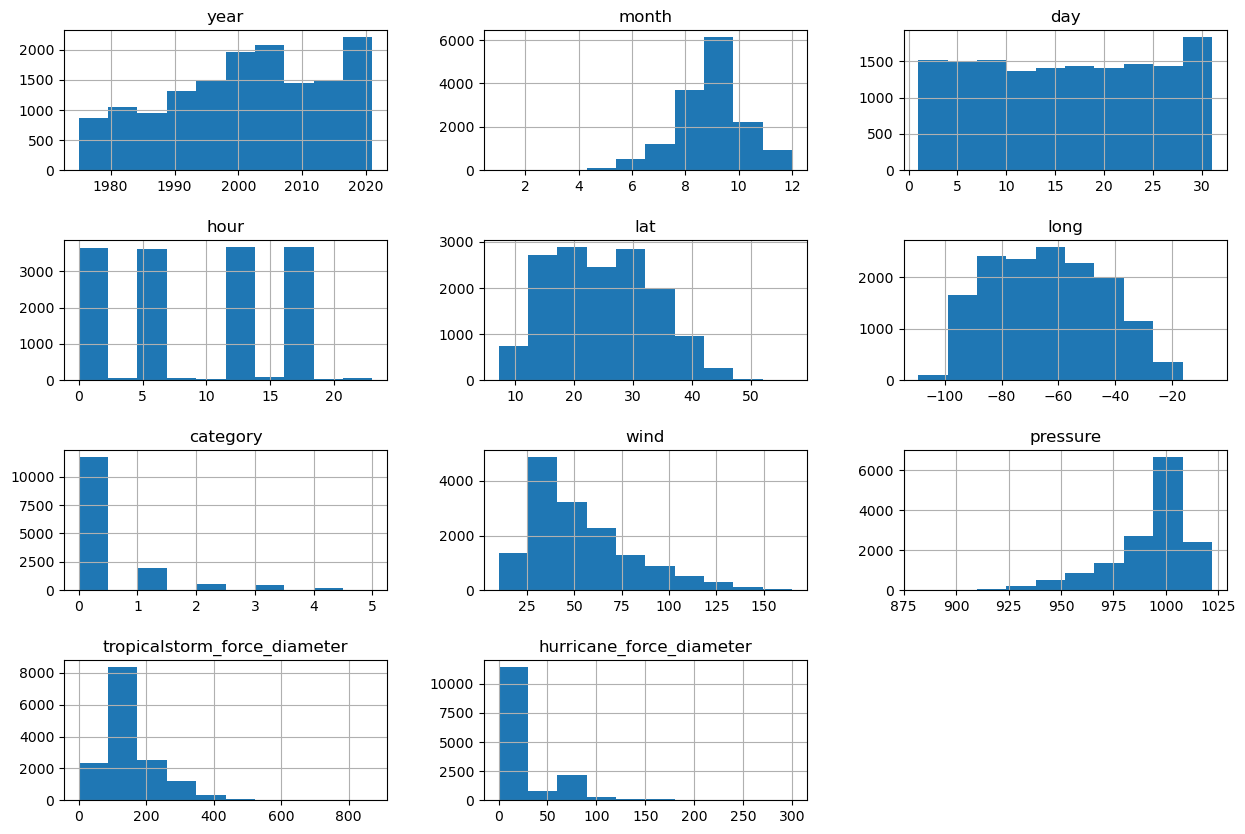

In [93]:
storms.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5);

In [94]:
#Filter the 'tropicalstorm_force_diameter' column for values greater than 500
storms['tropicalstorm_force_diameter'][storms['tropicalstorm_force_diameter'] > 700]

12858   750.00
12859   750.00
14339   780.00
14340   750.00
14341   750.00
14342   800.00
14343   850.00
14344   870.00
14345   820.00
14346   840.00
15878   750.00
15879   750.00
18157   740.00
18158   740.00
18159   740.00
Name: tropicalstorm_force_diameter, dtype: float64

In [95]:
#Filter the 'hurricane_force_diameter' column for values greater than 500
storms['hurricane_force_diameter'][storms['hurricane_force_diameter'] > 200]

14346   300.00
17483   230.00
17484   230.00
Name: hurricane_force_diameter, dtype: float64

In [96]:
storms_qty = storms.groupby('year')['status'].agg(['count','sum'])

In [97]:
storms_qty.head()

,count,sum
year,,
1975,216,tropical depressiontropical depressiontropical...
1976,120,tropical depressiontropical depressiontropical...
1977,82,tropical depressiontropical depressiontropical...
1978,136,tropical depressiontropical stormtropical stor...
1979,314,tropical depressiontropical depressiontropical...


In [196]:
storms

,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter
32,Blanche,1975,7,24,0,26.00,-68.40,tropical depression,0.00,20,1014,125.47,4.56
33,Blanche,1975,7,24,6,26.00,-69.50,tropical depression,0.00,20,1014,125.47,4.56
83,Caroline,1975,9,1,6,25.20,-98.70,tropical depression,0.00,20,1002,125.47,4.56
84,Caroline,1975,9,1,12,25.30,-99.00,tropical depression,0.00,20,1002,125.47,4.56
1,Amy,1975,6,27,0,27.50,-79.00,tropical depression,0.00,25,1013,125.47,4.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18949,Sam,2021,9,27,0,14.50,-50.60,hurricane,4.00,130,940,150.00,45.00
18966,Sam,2021,10,1,6,25.80,-61.60,hurricane,4.00,130,936,250.00,95.00
18967,Sam,2021,10,1,12,27.40,-61.90,hurricane,4.00,130,936,310.00,85.00
18968,Sam,2021,10,1,18,29.20,-61.90,hurricane,4.00,130,937,310.00,85.00


In [199]:
storms.sort_values(['year','wind','category','name'],inplace=True)

storms_qty = storms.drop_duplicates(subset = ['name','status'], keep='last').reset_index(drop=True)

In [200]:
storms_qty

,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter
0,Amy,1975,6,28,18,34.00,-77.00,tropical depression,0.00,30,1006,125.47,4.56
1,Blanche,1975,7,26,0,31.00,-75.00,tropical depression,0.00,30,1005,125.47,4.56
2,Caroline,1975,9,1,0,25.10,-98.30,tropical depression,0.00,30,1000,125.47,4.56
3,Eloise,1975,9,24,0,35.50,-84.30,tropical depression,0.00,30,999,125.47,4.56
4,Faye,1975,9,25,0,23.80,-57.20,tropical depression,0.00,30,1005,125.47,4.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,Elsa,2021,7,2,18,13.80,-62.40,hurricane,1.00,75,991,210.00,20.00
630,Grace,2021,8,21,5,20.60,-97.10,hurricane,2.00,105,967,210.00,60.00
631,Larry,2021,9,6,0,20.70,-51.20,hurricane,2.00,110,953,290.00,100.00
632,Ida,2021,8,29,16,29.10,-90.20,hurricane,4.00,130,931,220.00,65.00


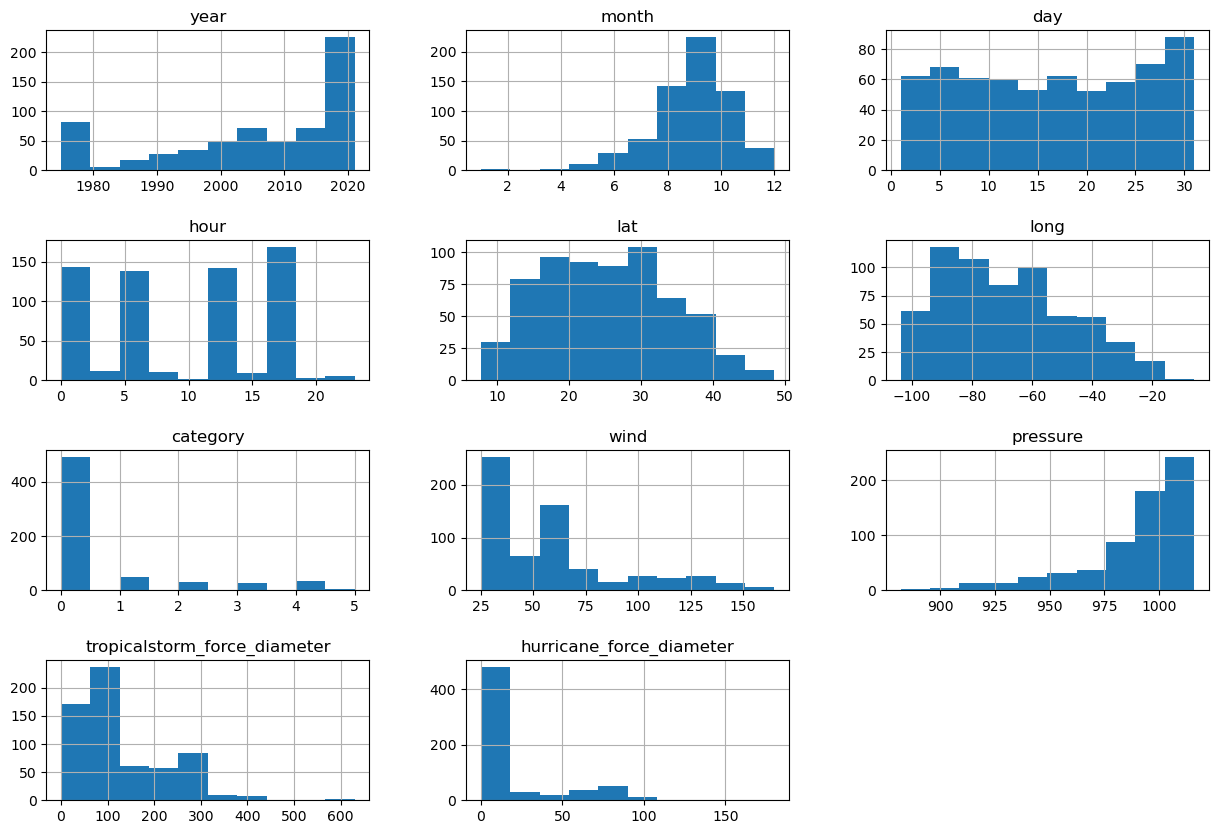

In [201]:
storms_qty.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5);

In [202]:
storms_qty['category'].value_counts()

category
0.00    491
1.00     50
4.00     34
2.00     30
3.00     25
5.00      4
Name: count, dtype: int64

In [205]:
storms_qty.drop('name', axis=1,inplace=True)

In [206]:
storms_qty.head()

,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter
0,1975,6,28,18,34.00,-77.00,tropical depression,0.00,30,1006,125.47,4.56
1,1975,7,26,0,31.00,-75.00,tropical depression,0.00,30,1005,125.47,4.56
2,1975,9,1,0,25.10,-98.30,tropical depression,0.00,30,1000,125.47,4.56
3,1975,9,24,0,35.50,-84.30,tropical depression,0.00,30,999,125.47,4.56
4,1975,9,25,0,23.80,-57.20,tropical depression,0.00,30,1005,125.47,4.56


In [215]:
X = storms_qty.drop('status', axis = 1)
y = storms_qty.status

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


In [216]:
logreg = LogisticRegression(solver='lbfgs')

In [217]:
pipe = make_pipeline(logreg)

In [218]:
cross_val_score(pipe, X_scaled, y, cv=2, scoring='accuracy').mean()

0.7965299684542586

In [219]:
X_new = X.sample(10,random_state =99)

In [220]:
pipe.fit(X_scaled, y)

Pipeline(steps=[('logisticregression', LogisticRegression())])

In [221]:
pipe.predict(X_new)

/Users/gabrielrosario/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array(['tropical storm', 'tropical storm', 'tropical storm',
       'tropical storm', 'tropical storm', 'tropical storm',
       'tropical storm', 'tropical storm', 'tropical storm',
       'tropical storm'], dtype=object)